# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

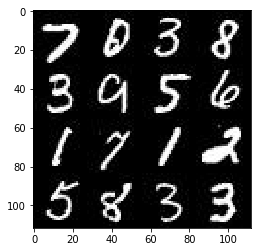

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

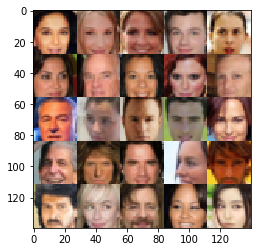

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate_, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 80
    
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={learning_rate: learning_rate_, inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={learning_rate: learning_rate_, inputs_real: batch_images, inputs_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_real: batch_images, inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)  
                    #gen_samples = sess.run(
                    #               generator(inputs_z, 3, is_train=False),
                    #               feed_dict={input_z: sample_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5683... Generator Loss: 7.2588
Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 6.1726
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 7.1763
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 1.1716


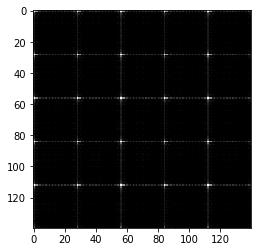

Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.6592
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 3.4323
Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 3.0028


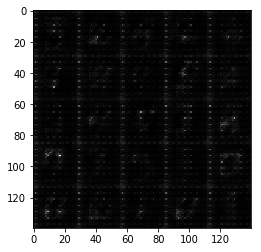

Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 1.9778
Epoch 1/2... Discriminator Loss: 0.6558... Generator Loss: 3.3050
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.1702


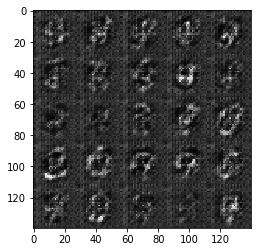

Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 4.8486
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.6410
Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.4959
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.0510


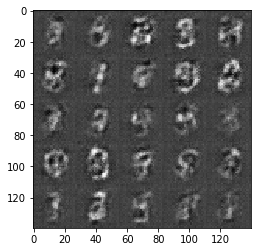

Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 2.5545
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 2.9166
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.0874


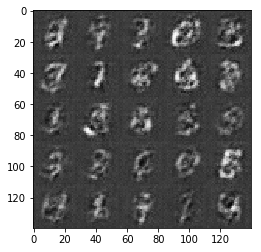

Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.6466
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.8817... Generator Loss: 0.3031
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 1.8513


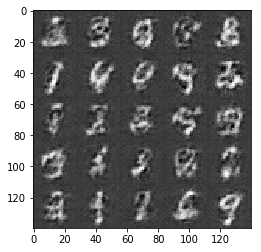

Epoch 1/2... Discriminator Loss: 0.4860... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 2.8988
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 1.3191
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.3511


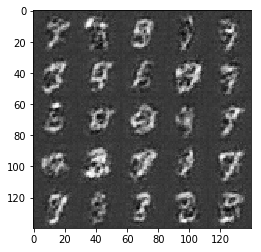

Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.8198
Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.5395... Generator Loss: 2.1077
Epoch 1/2... Discriminator Loss: 0.7302... Generator Loss: 2.0227


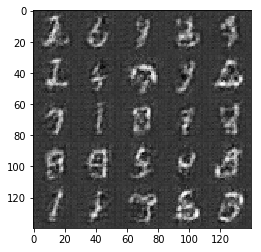

Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 0.5419... Generator Loss: 1.8851
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 2.2331
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 2.8147


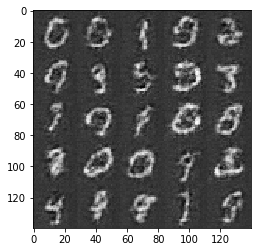

Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.6441
Epoch 1/2... Discriminator Loss: 4.4269... Generator Loss: 0.0453
Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 1.7801
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.4882


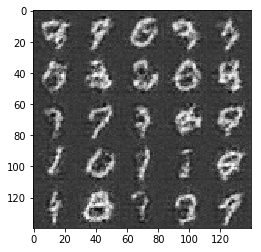

Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 2.2835
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 2.0202
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 2.2997
Epoch 1/2... Discriminator Loss: 0.5470... Generator Loss: 1.8555


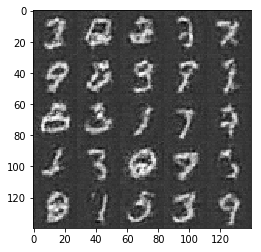

Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 2.4953
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.5564
Epoch 2/2... Discriminator Loss: 0.5313... Generator Loss: 1.9484
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.8006


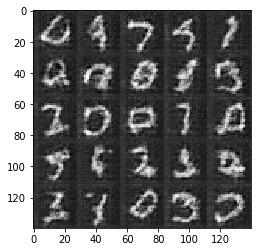

Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.4082
Epoch 2/2... Discriminator Loss: 0.6824... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 1.9782
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 1.8135


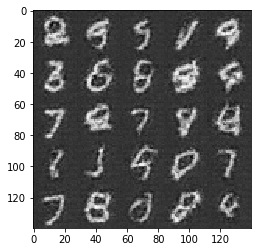

Epoch 2/2... Discriminator Loss: 0.4416... Generator Loss: 2.4701
Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 1.8299
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.1600
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.5056


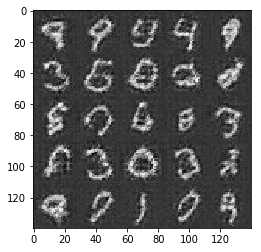

Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 2.5013
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 2.8776
Epoch 2/2... Discriminator Loss: 0.4142... Generator Loss: 2.7220
Epoch 2/2... Discriminator Loss: 0.4563... Generator Loss: 2.4261


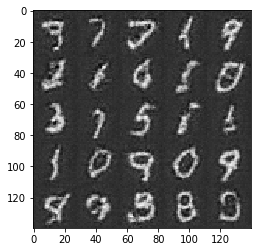

Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.5096
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.2465
Epoch 2/2... Discriminator Loss: 0.3947... Generator Loss: 3.0723
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 3.4128


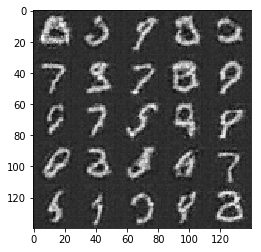

Epoch 2/2... Discriminator Loss: 0.4087... Generator Loss: 2.9359
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 3.4084
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.8241
Epoch 2/2... Discriminator Loss: 1.5790... Generator Loss: 1.6753


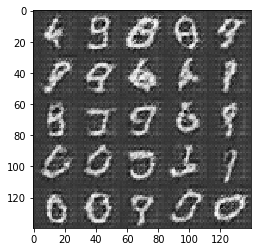

Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.4835
Epoch 2/2... Discriminator Loss: 0.3914... Generator Loss: 3.2168
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 0.8891


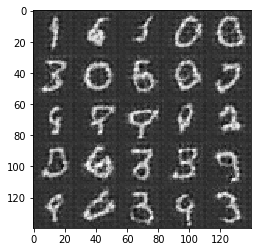

Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 2.1517
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.1499
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 2.5442
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.9470


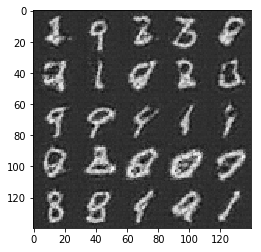

Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 2.3713
Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 3.1031
Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 2.7660
Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 2.2381


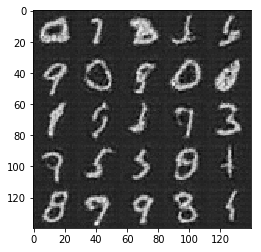

Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 2.1567
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.5992
Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 2.0568


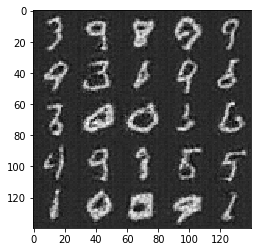

Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 2.5452
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 2.5568
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.6343
Epoch 2/2... Discriminator Loss: 0.4263... Generator Loss: 2.9923


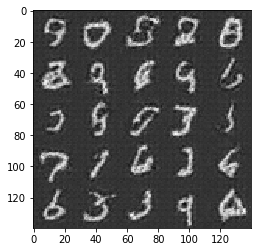

Epoch 2/2... Discriminator Loss: 0.4524... Generator Loss: 3.4158
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 4.3409
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 1.9757
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.4279


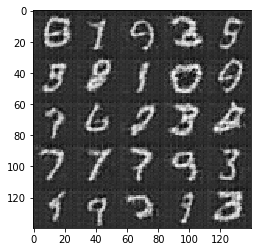

Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 0.9714


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
#Epoch 2/2... Discriminator Loss: 0.4178... Generator Loss: 4.3547


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 2.4123... Generator Loss: 0.1561
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 4.6040
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 2.6021


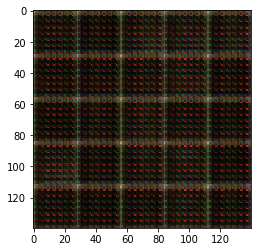

Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 2.5390
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 2.0972


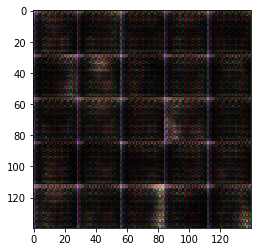

Epoch 1/1... Discriminator Loss: 2.2303... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 3.2513
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 3.7708


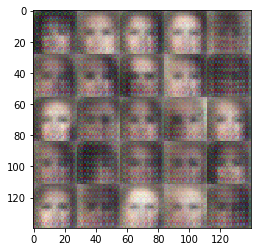

Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 5.0490
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 3.7755
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.1494


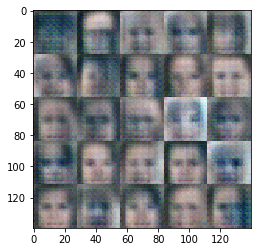

Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 3.2116


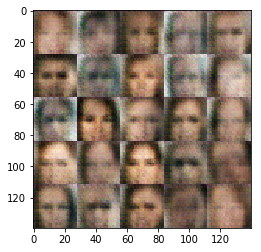

Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 2.1075... Generator Loss: 0.2465
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 6.3914
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 4.9302


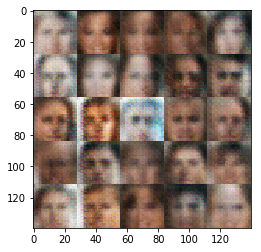

Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.9520
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.4945
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 6.3934


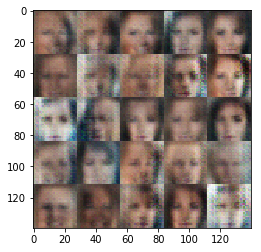

Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 3.7598
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 1.7390
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.1051
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.8144


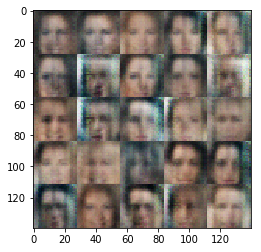

Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 7.3086
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 5.1752
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.2844
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 9.9987


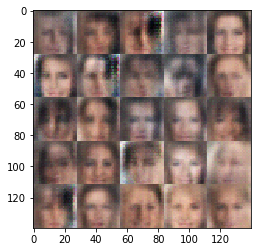

Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.7080
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 7.8364
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.5111
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 3.2644


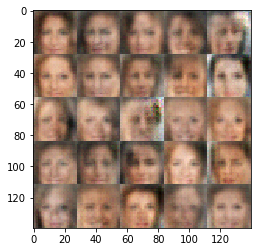

Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 4.0043
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 7.2674
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 7.4580
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.7040


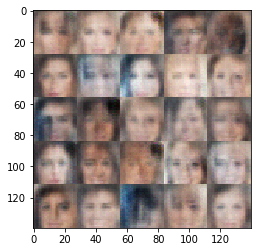

Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 5.8339
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.8583
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.6907


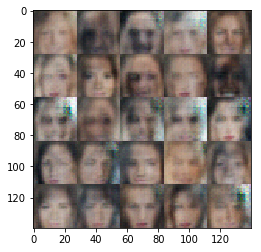

Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 6.8101
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 4.0659
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 8.6049
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 4.8040


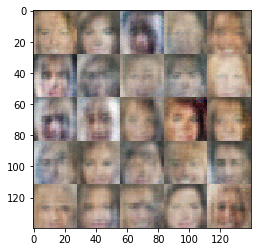

Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 4.0544
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 7.1065
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 3.5380


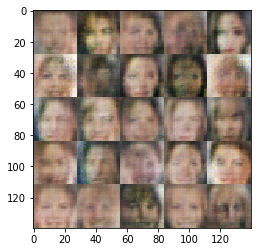

Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.7301
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 6.1026
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 4.5075


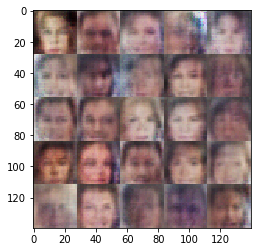

Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.4714
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 2.6793
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 4.2751
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 6.7801


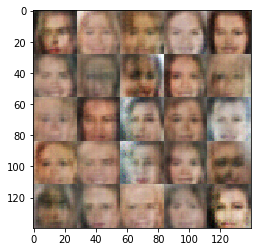

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.3752
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 5.5392
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 5.7205


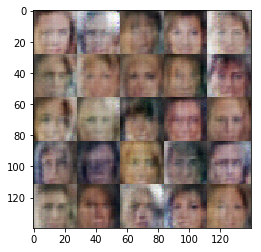

Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 6.5195
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 3.7066
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 3.5921
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 7.0292


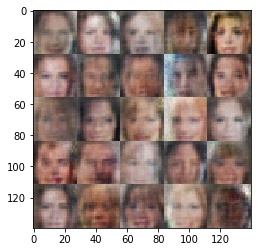

Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 6.3297
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.4495
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 4.6447
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 6.9001


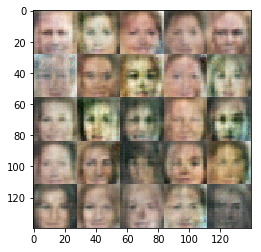

Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 7.1573
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.6028
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 3.6184
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 4.6989


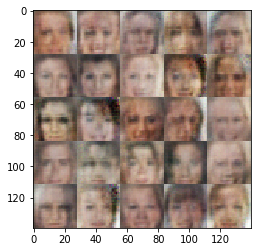

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 8.4390
Epoch 1/1... Discriminator Loss: 3.4222... Generator Loss: 4.7900
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.4086
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.7975


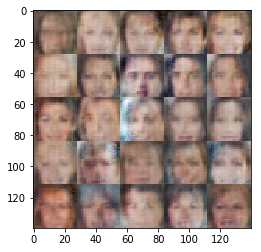

Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 7.3286
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 6.8737
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.9531
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 8.1494


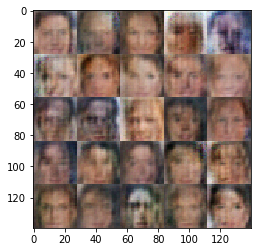

Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 5.3239
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 3.6196
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.4578


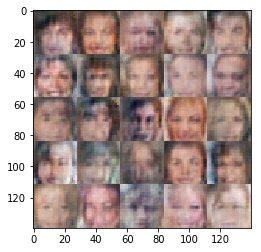

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.3635
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.4735
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.5400


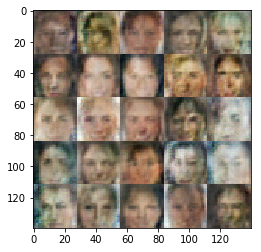

Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 6.2596
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 8.3629
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.3737
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 6.0694


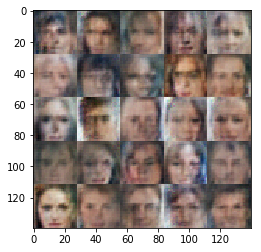

Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 2.1460
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 2.1647
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 3.8379
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.1132


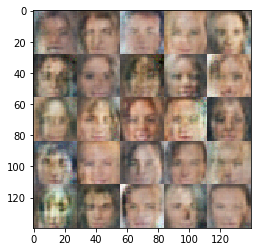

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.5097
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 11.0436
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 10.7227
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 8.1413


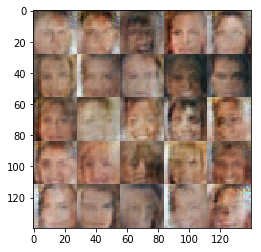

Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.1905


KeyboardInterrupt: 

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.